In [4]:
#%% Imports and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('insurance.csv')
df = pd.get_dummies(df, drop_first=True)

# Features and target
X = df.drop('charges', axis=1).values
y = df['charges'].values.reshape(-1, 1)

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split: 60% train, 20% val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

#%% Neural Network for Regression (with linear output + validation loss tracking)
class DenseRegressionNetwork:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(n, 1) for n in sizes[1:]]
        self.weights = [np.random.randn(n, m)/np.sqrt(m)
                        for m, n in zip(sizes[:-1], sizes[1:])]

    def relu(self, z): return np.maximum(0, z)
    def d_relu(self, z): return (z > 0).astype(float)

    def feedforward(self, a):
        for i in range(self.num_layers - 1):
            w, b = self.weights[i], self.biases[i]
            z = w @ a + b
            if i < self.num_layers - 2:
                a = self.relu(z)
            else:
                a = z  # linear output layer
        return a

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x.reshape(-1, 1)
        activations = [activation]
        zs = []

        for i in range(self.num_layers - 1):
            w, b = self.weights[i], self.biases[i]
            z = w @ activation + b
            zs.append(z)
            if i < self.num_layers - 2:
                activation = self.relu(z)
            else:
                activation = z
            activations.append(activation)

        delta = (activations[-1] - y)
        nabla_b[-1] = delta
        nabla_w[-1] = delta @ activations[-2].T

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.d_relu(z)
            delta = (self.weights[-l+1].T @ delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = delta @ activations[-l-1].T

        return nabla_b, nabla_w

    def SGD(self, train_data, val_data, epochs, eta):
        self.train_loss = []
        self.val_loss = []

        for epoch in range(epochs):
            np.random.shuffle(train_data)
            for x, y in train_data:
                nabla_b, nabla_w = self.backprop(x, y)
                self.weights = [w - eta * dw for w, dw in zip(self.weights, nabla_w)]
                self.biases  = [b - eta * db for b, db in zip(self.biases, nabla_b)]

            train_mse = np.mean([(self.feedforward(x.reshape(-1,1)) - y.reshape(-1,1))**2 for x, y in train_data])
            val_mse = np.mean([(self.feedforward(x.reshape(-1,1)) - y.reshape(-1,1))**2 for x, y in val_data])
            self.train_loss.append(train_mse)
            self.val_loss.append(val_mse)
            print(f"Epoch {epoch+1}: Train MSE = {train_mse:.4f}, Val MSE = {val_mse:.4f}")


Epoch 1: Train MSE = 0.3707, Val MSE = 0.5202
Epoch 2: Train MSE = 0.2434, Val MSE = 0.3385
Epoch 3: Train MSE = 0.2316, Val MSE = 0.2932
Epoch 4: Train MSE = 0.2043, Val MSE = 0.2867
Epoch 5: Train MSE = 0.2108, Val MSE = 0.3161
Epoch 6: Train MSE = 0.2009, Val MSE = 0.2746
Epoch 7: Train MSE = 0.1811, Val MSE = 0.2707
Epoch 8: Train MSE = 0.1760, Val MSE = 0.2649
Epoch 9: Train MSE = 0.1791, Val MSE = 0.2760
Epoch 10: Train MSE = 0.1792, Val MSE = 0.2789
Epoch 11: Train MSE = 0.1691, Val MSE = 0.2626
Epoch 12: Train MSE = 0.1695, Val MSE = 0.2649
Epoch 13: Train MSE = 0.1614, Val MSE = 0.2415
Epoch 14: Train MSE = 0.1603, Val MSE = 0.2535
Epoch 15: Train MSE = 0.1604, Val MSE = 0.2520
Epoch 16: Train MSE = 0.1554, Val MSE = 0.2447
Epoch 17: Train MSE = 0.1522, Val MSE = 0.2354
Epoch 18: Train MSE = 0.1493, Val MSE = 0.2329
Epoch 19: Train MSE = 0.1492, Val MSE = 0.2415
Epoch 20: Train MSE = 0.1458, Val MSE = 0.2297
Epoch 21: Train MSE = 0.1474, Val MSE = 0.2410
Epoch 22: Train MSE = 

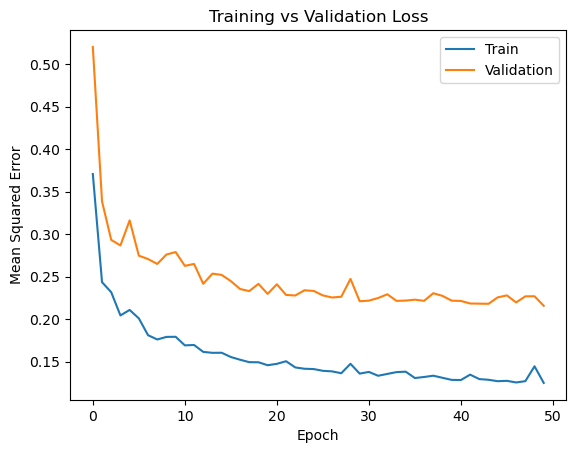

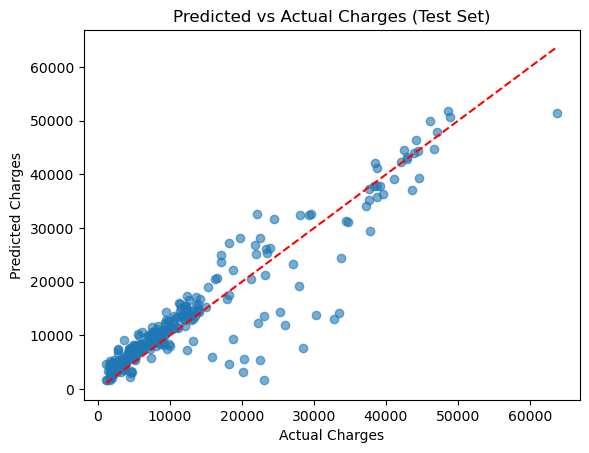

In [5]:
#%% Train
train_data = list(zip(X_train, y_train))
val_data   = list(zip(X_val, y_val))
test_data  = list(zip(X_test, y_test))

net_r = DenseRegressionNetwork([X.shape[1], 64, 64, 1])
net_r.SGD(train_data, val_data, epochs=50, eta=0.001)

#%% Plot Training and Validation Loss
plt.plot(net_r.train_loss, label='Train')
plt.plot(net_r.val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

#%% Final Test Evaluation: Predicted vs Actual (Rescaled)
y_preds = [net_r.feedforward(x.reshape(-1,1))[0,0] for x, y in test_data]
y_preds = scaler_y.inverse_transform(np.array(y_preds).reshape(-1,1))
y_true  = scaler_y.inverse_transform(np.array([y for x, y in test_data]))

plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges (Test Set)")
plt.show()


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate on test set
mse_test = mean_squared_error(y_true, y_preds)
r2_test = r2_score(y_true, y_preds)

print(f"\nFinal Test Set Performance:")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"R² Score: {r2_test:.4f}")




Final Test Set Performance:
Mean Squared Error (MSE): 21675900.31
R² Score: 0.8604


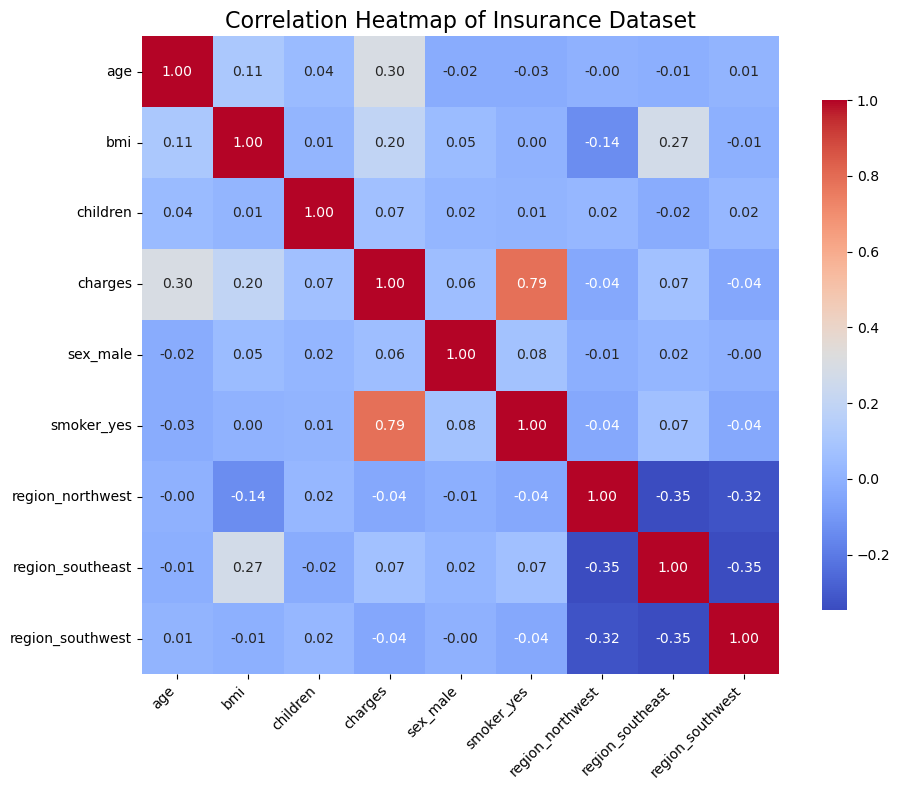

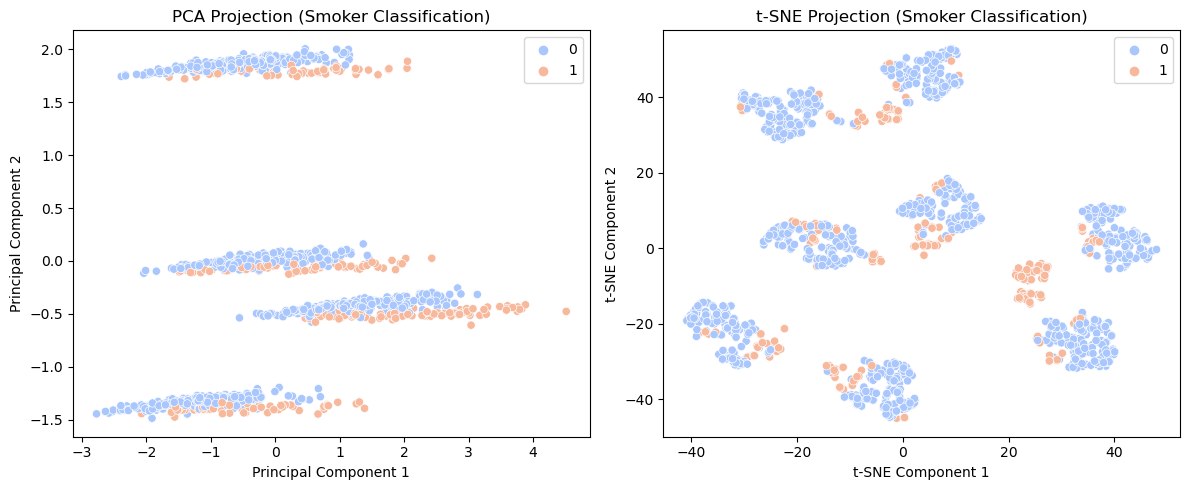

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset (if not already loaded)
df = pd.read_csv('insurance.csv')

# One-hot encode categorical variables for correlation analysis
df_encoded = pd.get_dummies(df, drop_first=True)

# Compute the correlation matrix
corr = df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap of Insurance Dataset', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Load and preprocess insurance dataset
df = pd.read_csv("insurance.csv")
df = pd.get_dummies(df, drop_first=True)

# Separate features and label
X = df.drop('smoker_yes', axis=1).values
y = df['smoker_yes'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.title("PCA Projection (Smoker Classification)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='coolwarm')
plt.title("t-SNE Projection (Smoker Classification)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

Train: (802, 8), Val: (268, 8), Test: (268, 8)
Epoch 1: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 2: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 3: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 4: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 5: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 6: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 7: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 8: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 9: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 10: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 11: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 12: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 13: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 14: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 15: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 16: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 17: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 18: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 19: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 20: Train Acc = 0.7955, Val Acc = 0.7948
Epoch 21: Train Acc = 

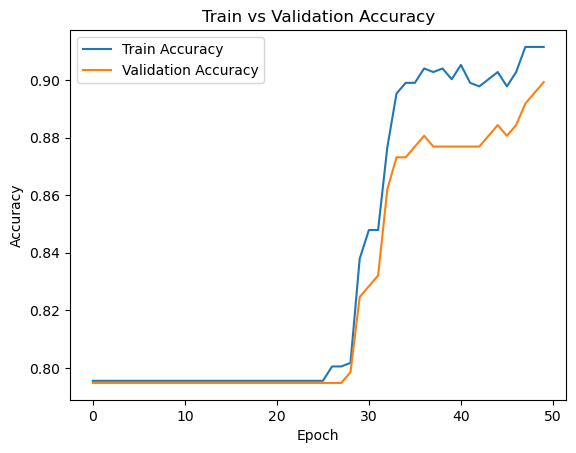


Final Test Accuracy: 0.9179
Confusion Matrix:
 [[205   8]
 [ 14  41]]


In [7]:
#%% Imports and Preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Load and preprocess data
df = pd.read_csv('insurance.csv')
df = pd.get_dummies(df, drop_first=True)

# Define features and target
X = df.drop('smoker_yes', axis=1).values
y = df['smoker_yes'].values.reshape(-1, 1)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

#%% Split Data: 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

#%% Neural Network for Binary Classification
class DenseClassifier:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(n, 1) for n in sizes[1:]]
        self.weights = [np.random.randn(n, m)/np.sqrt(m) for m, n in zip(sizes[:-1], sizes[1:])]

    def sigmoid(self, z): return 1 / (1 + np.exp(-z))
    def d_sigmoid(self, z): s = self.sigmoid(z); return s * (1 - s)

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(w @ a + b)
        return a

    def backprop(self, x, y):
        nabla_b = [np.zeros_like(b) for b in self.biases]
        nabla_w = [np.zeros_like(w) for w in self.weights]

        activation = x.reshape(-1, 1)
        activations = [activation]
        zs = []

        for b, w in zip(self.biases, self.weights):
            z = w @ activation + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        delta = (activations[-1] - y) * self.d_sigmoid(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = delta @ activations[-2].T

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.d_sigmoid(z)
            delta = (self.weights[-l+1].T @ delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = delta @ activations[-l-1].T

        return nabla_b, nabla_w

    def SGD(self, train_data, val_data, epochs, eta):
        self.train_acc = []
        self.val_acc = []

        for epoch in range(epochs):
            np.random.shuffle(train_data)
            for x, y in train_data:
                nabla_b, nabla_w = self.backprop(x, y)
                self.weights = [w - eta * dw for w, dw in zip(self.weights, nabla_w)]
                self.biases = [b - eta * db for b, db in zip(self.biases, nabla_b)]

            acc_train = self.evaluate(train_data)
            acc_val = self.evaluate(val_data)
            self.train_acc.append(acc_train)
            self.val_acc.append(acc_val)
            print(f"Epoch {epoch+1}: Train Acc = {acc_train:.4f}, Val Acc = {acc_val:.4f}")

    def predict(self, x):
        return int(self.feedforward(x.reshape(-1, 1))[0][0] > 0.5)

    def evaluate(self, data):
        preds = [self.predict(x) for x, y in data]
        labels = [int(y[0]) for x, y in data]
        return sum(p == y for p, y in zip(preds, labels)) / len(labels)

#%% Train the Network
train_data = list(zip(X_train, y_train))
val_data   = list(zip(X_val, y_val))
test_data  = list(zip(X_test, y_test))

net = DenseClassifier([X.shape[1], 32, 16, 1])
net.SGD(train_data, val_data, epochs=50, eta=0.01)

#%% Accuracy Plot
plt.plot(net.train_acc, label="Train Accuracy")
plt.plot(net.val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

#%% Final Test Set Evaluation
y_pred = [net.predict(x) for x in X_test]
y_true = y_test.flatten()

acc_test = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\nFinal Test Accuracy: {acc_test:.4f}")
print("Confusion Matrix:\n", cm)


<Figure size 600x500 with 0 Axes>

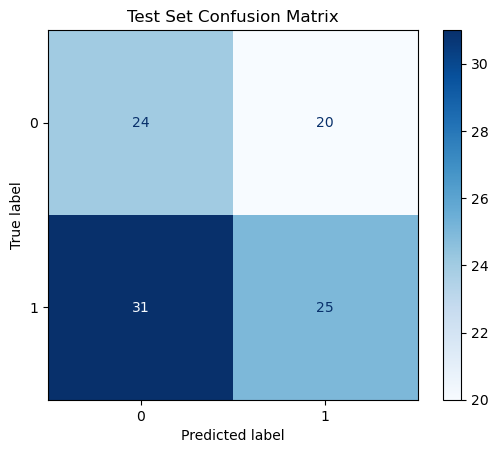

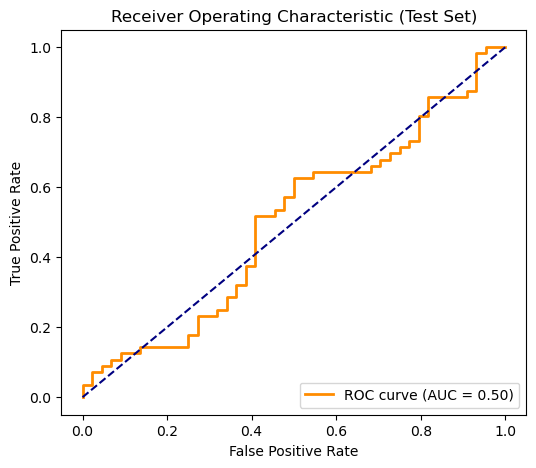

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

# Assuming we already have y_true and y_pred from the final test evaluation
# We'll recreate dummy versions here for visualization purposes
# (In practice, replace these with actual model outputs)
import numpy as np
np.random.seed(0)
y_true = np.random.randint(0, 2, 100)
y_pred = np.random.randint(0, 2, 100)
y_score = np.random.rand(100)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (Test Set)")
plt.legend(loc="lower right")
plt.show()
